### Import

In [1]:
import os
import re  
import fnmatch 
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

### Path

In [2]:
parquet_dir = '.../Data/parquet/'

### Read Population Labels

In [3]:
pop_labels = pd.read_csv(parquet_dir + 'igsr_samples.tsv', sep='\t')
pop_labels.head(3)

Sample name     Sex Biosample ID Population code Population name  \
0     HG00271    male   SAME123417             FIN         Finnish   
1     HG00276  female   SAME123424             FIN         Finnish   
2     HG00288  female  SAME1839246             FIN         Finnish   

  Superpopulation code Superpopulation name Population elastic ID  \
0                  EUR    European Ancestry                   FIN   
1                  EUR    European Ancestry                   FIN   
2                  EUR    European Ancestry                   FIN   

                                    Data collections  
0  1000 Genomes on GRCh38,1000 Genomes 30x on GRC...  
1  1000 Genomes on GRCh38,1000 Genomes 30x on GRC...  
2  1000 Genomes on GRCh38,1000 Genomes 30x on GRC...

### Read Data

In [4]:
df = pd.read_parquet(parquet_dir + "Final_Data.parquet", engine='pyarrow')
result_df = df.transpose()
result_df.head(3)

rs12124819  rs6681049  rs4970383  rs4475691  rs7537756  rs3748597  \
Person_ID                                                                      
HG00096           0.0        2.0        0.0        0.0        0.0        2.0   
HG00097           0.0        2.0        1.0        1.0        1.0        2.0   
HG00099           0.0        2.0        0.0        0.0        0.0        2.0   

           rs28391282  rs2340592  rs1891910  rs3128117  ...  rs739365  \
Person_ID                                               ...             
HG00096           0.0        1.0        1.0        2.0  ...       0.0   
HG00097           0.0        1.0        0.0        1.0  ...       0.0   
HG00099           0.0        0.0        0.0        0.0  ...       0.0   

           rs5770992  rs2040487  rs9628187  rs6010063  rs10451  rs715586  \
Person_ID                                                                  
HG00096          0.0        2.0        0.0        1.0      0.0       1.0   
HG00097          0.0        1.0        0.0        0.0      0.0       0.0   
HG00099          0.0        1.0        0.0        1.0      1.0       0.0   

           rs8137951  rs2301584  rs3810648  
Person_ID                                   
HG00096          0.0        0.0        0.0  
HG00097          0.0        0.0        0.0  
HG00099          1.0        0.0        0.0  

[3 rows x 477372 columns]

### Preparing Population Codes

In [5]:
pop_labels = pop_labels[pop_labels['Sample name'].isin(result_df.index)]
pop_labels = pop_labels[['Sample name', 'Population code']]
pop_labels.rename(columns={"Sample name": "Person_ID", "Population code": "labels"}, inplace=True)
pop_labels.loc[pop_labels.labels == 'IBS,MSL', 'labels'] = 'IBS'
pop_labels.head(3)

Person_ID labels
0   HG00271    FIN
1   HG00276    FIN
2   HG00288    FIN

In [6]:
def plot_label_distribution(df):

    all_labels = df['labels'].str.split(',').sum()
    label_counts = Counter(all_labels)
    label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count']).sort_values('Count', ascending=True)

    plt.figure(figsize=(18, 6))
    plt.bar(label_df['Label'], label_df['Count'], color='skyblue', edgecolor='blue')
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Labels', fontsize=12)
    plt.title('Distribution of Labels in Dataset', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout() 
    plt.show()

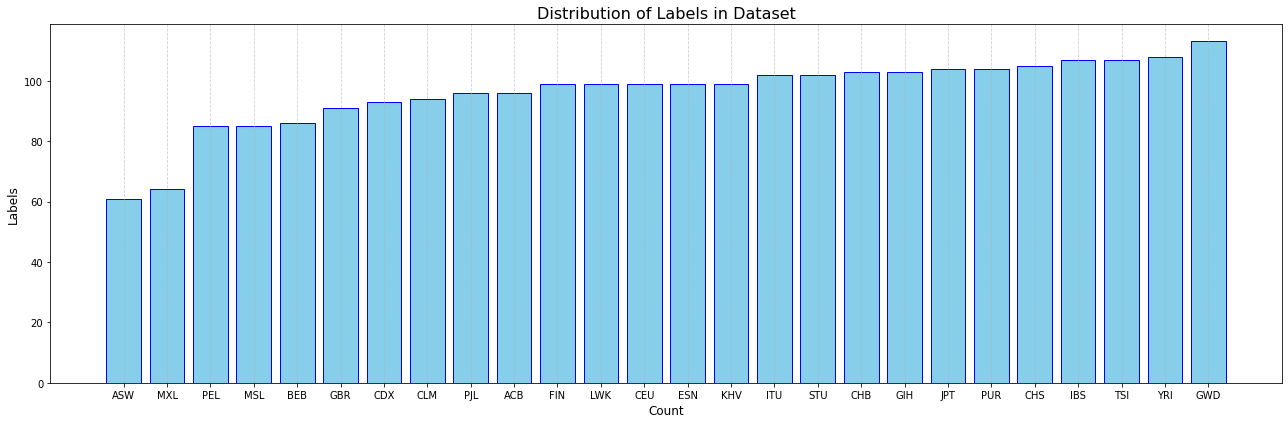

In [7]:
plot_label_distribution(pop_labels)

In [11]:
code = pd.read_csv(parquet_dir + 'igsr_samples.tsv', sep='\t')
code = code[['Population code', 'Superpopulation code']]
code = code.drop_duplicates()
code.rename(columns={"Population code": "labels"}, inplace=True)
code.loc[code.labels == 'IBS,MSL', 'labels'] = 'IBS'
code.loc[code['Superpopulation code'] == 'EUR,AFR', 'Superpopulation code'] = 'EUR'
all_labels = pop_labels['labels'].str.split(',').sum()
label_counts = Counter(all_labels)
label_df = pd.DataFrame(label_counts.items(), columns=['labels', 'Count']).sort_values('Count', ascending=True)
label_df = label_df.merge(code, on='labels', how='left')
label_df = label_df.sort_values(by=['Superpopulation code', 'Count'])

In [41]:
def plot_code_distribution(df):

    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 7), dpi=300)
    
    sns.barplot(x=df['labels'], y=df['Count'], hue=df['Superpopulation code'], linewidth=0.5, dodge=False, edgecolor='black', alpha=0.9)
    
    plt.legend(title='Population Code', title_fontsize='12', fontsize='15', bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('Population Sample Frequencies', fontsize=16)
    plt.xlabel('Population Codes',  fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(rotation=35)  
    plt.tight_layout() 
    plt.show()

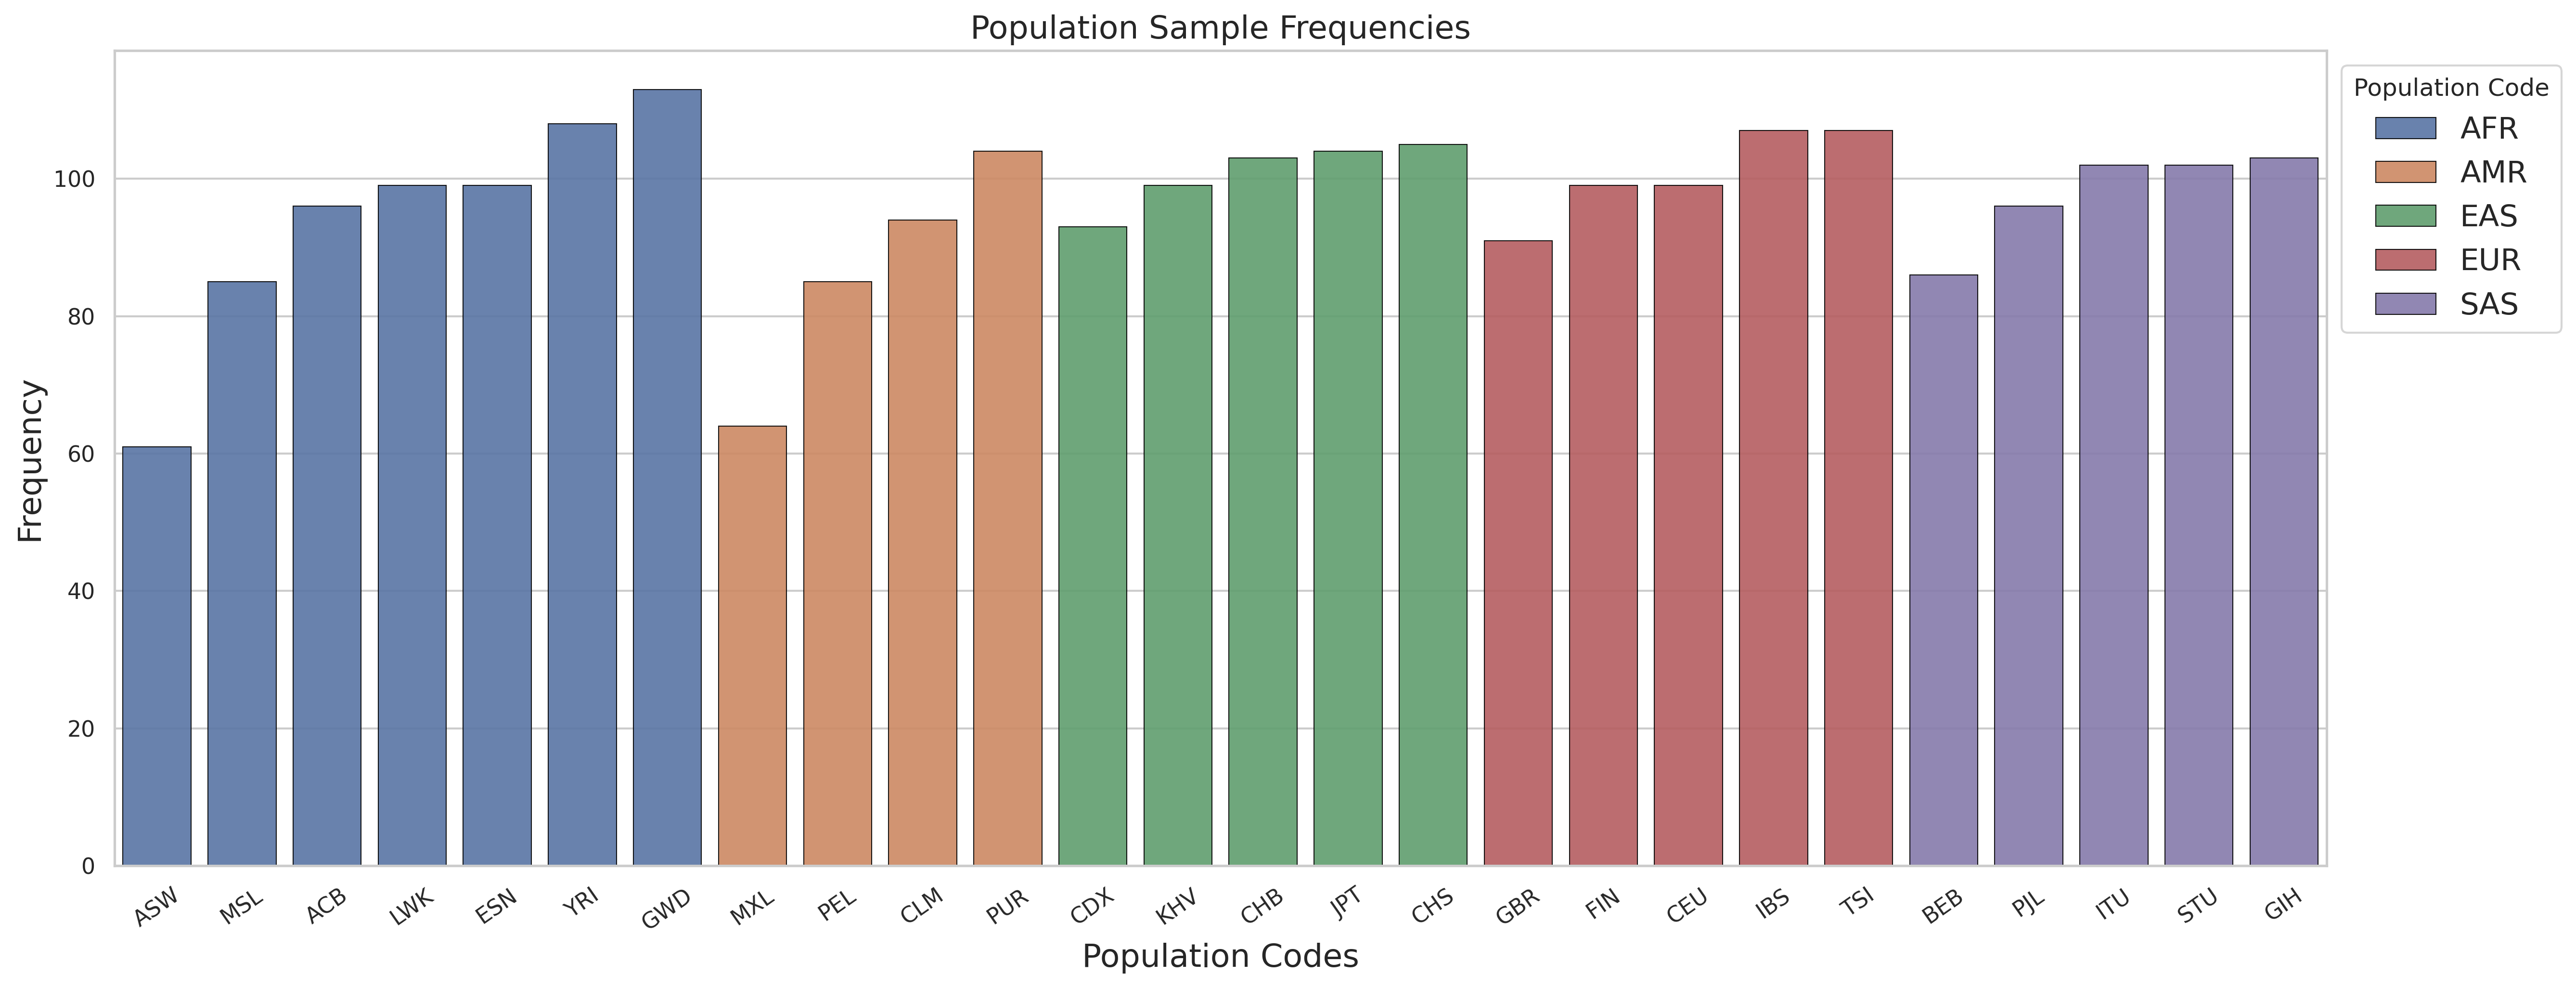

In [42]:
plot_code_distribution(label_df)

### Principal Component Analysis (PCA)

In [8]:
def apply_pca(df, n_components=None, explained_variance=None):

    if n_components is not None:
        pca = PCA(n_components=n_components, random_state=42)
    elif explained_variance is not None:
        pca = PCA(n_components=explained_variance, random_state=42)
    else:
        pca = PCA(random_state=42)
    
    principal_components = pca.fit_transform(df)
    
    col_names = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    
    pca_df = pd.DataFrame(data=principal_components, columns=col_names, index=df.index)
    
    return pca_df

### Singular Value Decomposition (SVD)

In [9]:
def apply_svd_sklearn(df, n_components=100):

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    
    principal_components = svd.fit_transform(df)
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    
    svd_df = pd.DataFrame(data=principal_components, columns=col_names, index=df.index)
    
    return svd_df

### t-SNE

In [10]:
def apply_tsne(df, n_components=2, perplexity=30, random_state=42):

    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(df)
    
    col_names = [f'TSNE{i+1}' for i in range(n_components)]
    tsne_df = pd.DataFrame(data=tsne_results, columns=col_names, index=df.index)
    
    return tsne_df

### UMAP

In [11]:
def apply_umap(df, n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):

    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    umap_results = reducer.fit_transform(df)
    
    col_names = [f'UMAP{i+1}' for i in range(n_components)]
    umap_df = pd.DataFrame(data=umap_results, columns=col_names, index=df.index)
    
    return umap_df

### Normalizing

In [12]:
def Normalizing(df):
    
    norm = df.columns
    df_val = df[norm]
    
    scaler = MinMaxScaler().fit(df_val.values)
    df_normalized = scaler.transform(df_val.values)

    df[norm] = df_normalized
    df = df.round(3)
    
    return df

### Adding Label

In [13]:
def adding_label(df, labels_df):
    
    df = df.reset_index()
    df = df.merge(labels_df, on='Person_ID', how='left')
    
    return df

### Scatter Plot

In [29]:
def plot_detailed_scatter(df, x_col, y_col, label_col):

    if not isinstance(df, pd.DataFrame) or x_col not in df.columns or y_col not in df.columns or label_col not in df.columns:
        raise ValueError("Invalid input parameters.")
    
    plt.figure(figsize=(12, 8), dpi=300)  
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='labels', palette='bright', s=100, edgecolor='black', alpha=0.6)
    
    plt.title(f'Scatter Plot of {x_col} vs {y_col}', fontsize=18)
    plt.xlabel(x_col, fontsize=14)
    plt.ylabel(y_col, fontsize=14)
    plt.legend(title=label_col, title_fontsize='12', fontsize='12', bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()  
    
    plt.show()

## PCA

In [15]:
pca = apply_pca(result_df, n_components=2, explained_variance=None)
pca = Normalizing(pca)
pca = adding_label(pca, pop_labels)
pca = pca.drop('Person_ID', axis=1)

In [16]:
pca.head(3)

PC1    PC2 labels
0  0.159  0.041    GBR
1  0.160  0.029    GBR
2  0.160  0.039    GBR

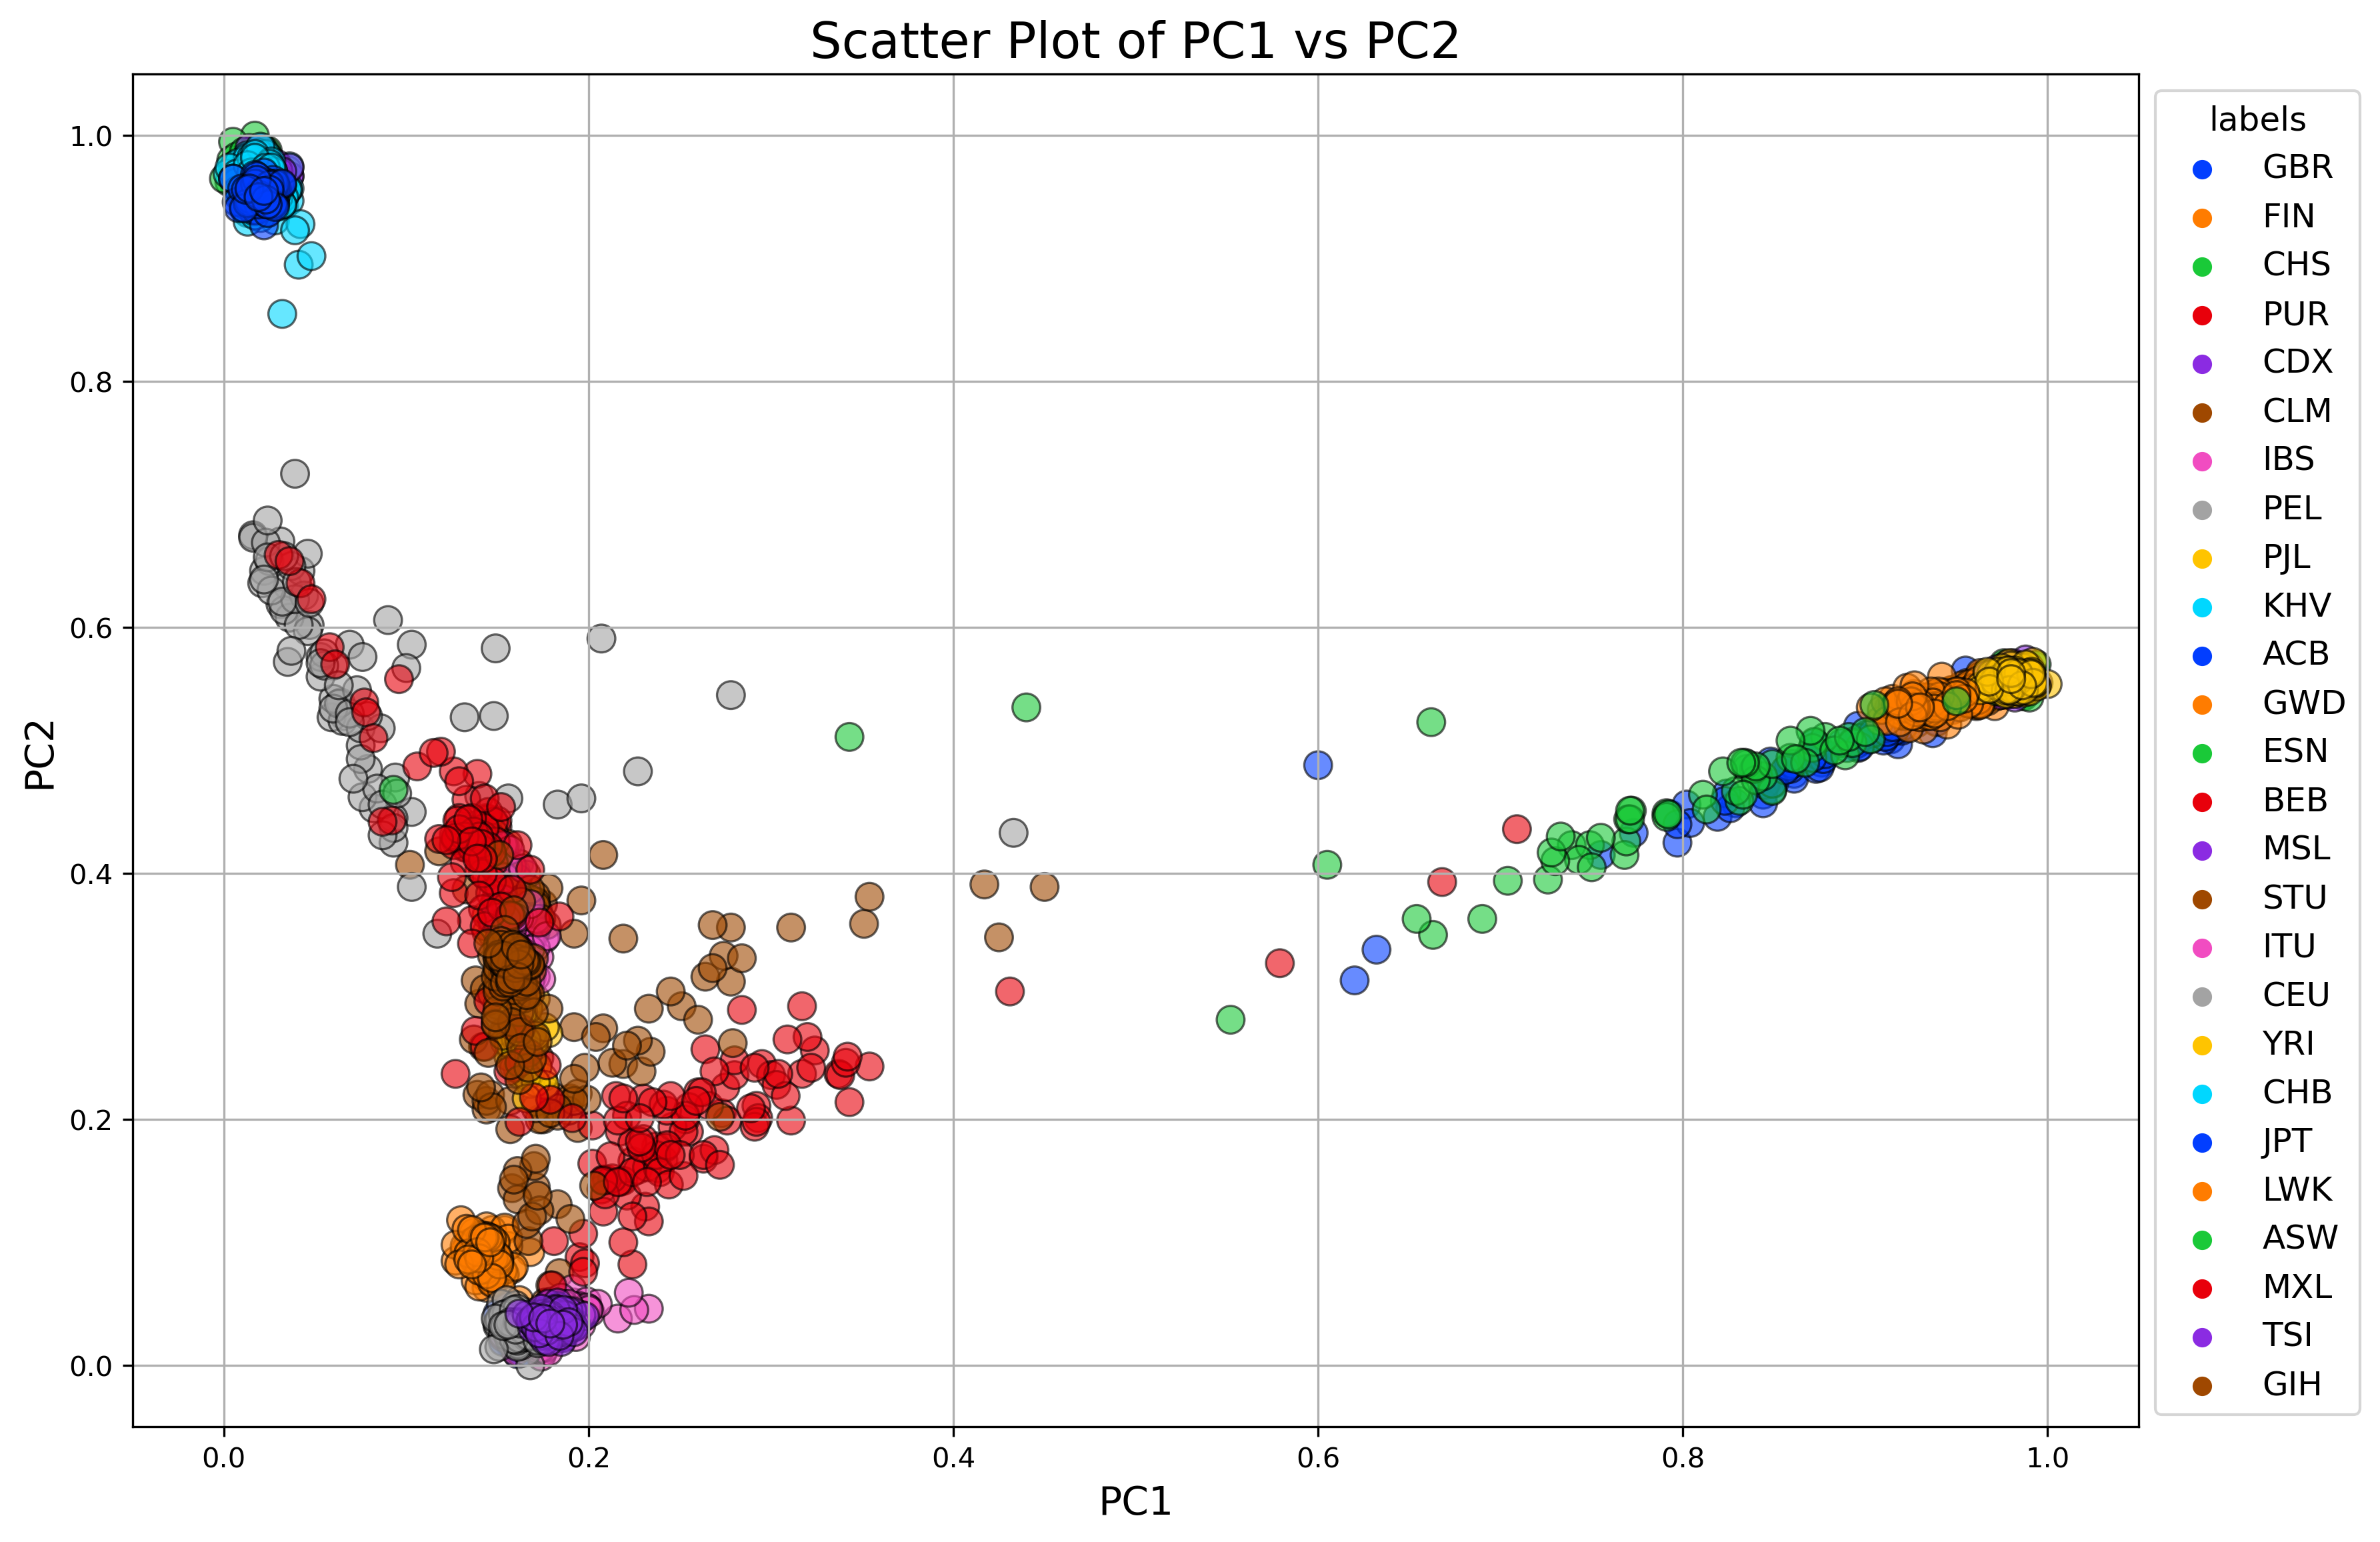

In [30]:
plot_detailed_scatter(pca, 'PC1', 'PC2', 'labels')

## SVD

In [18]:
svd = apply_svd_sklearn(result_df, n_components=2)
svd = Normalizing(svd)
svd = adding_label(svd, pop_labels)
svd = svd.drop('Person_ID', axis=1)

In [19]:
svd.head(3)

SVD1   SVD2 labels
0  0.244  0.149    GBR
1  0.167  0.150    GBR
2  0.340  0.151    GBR

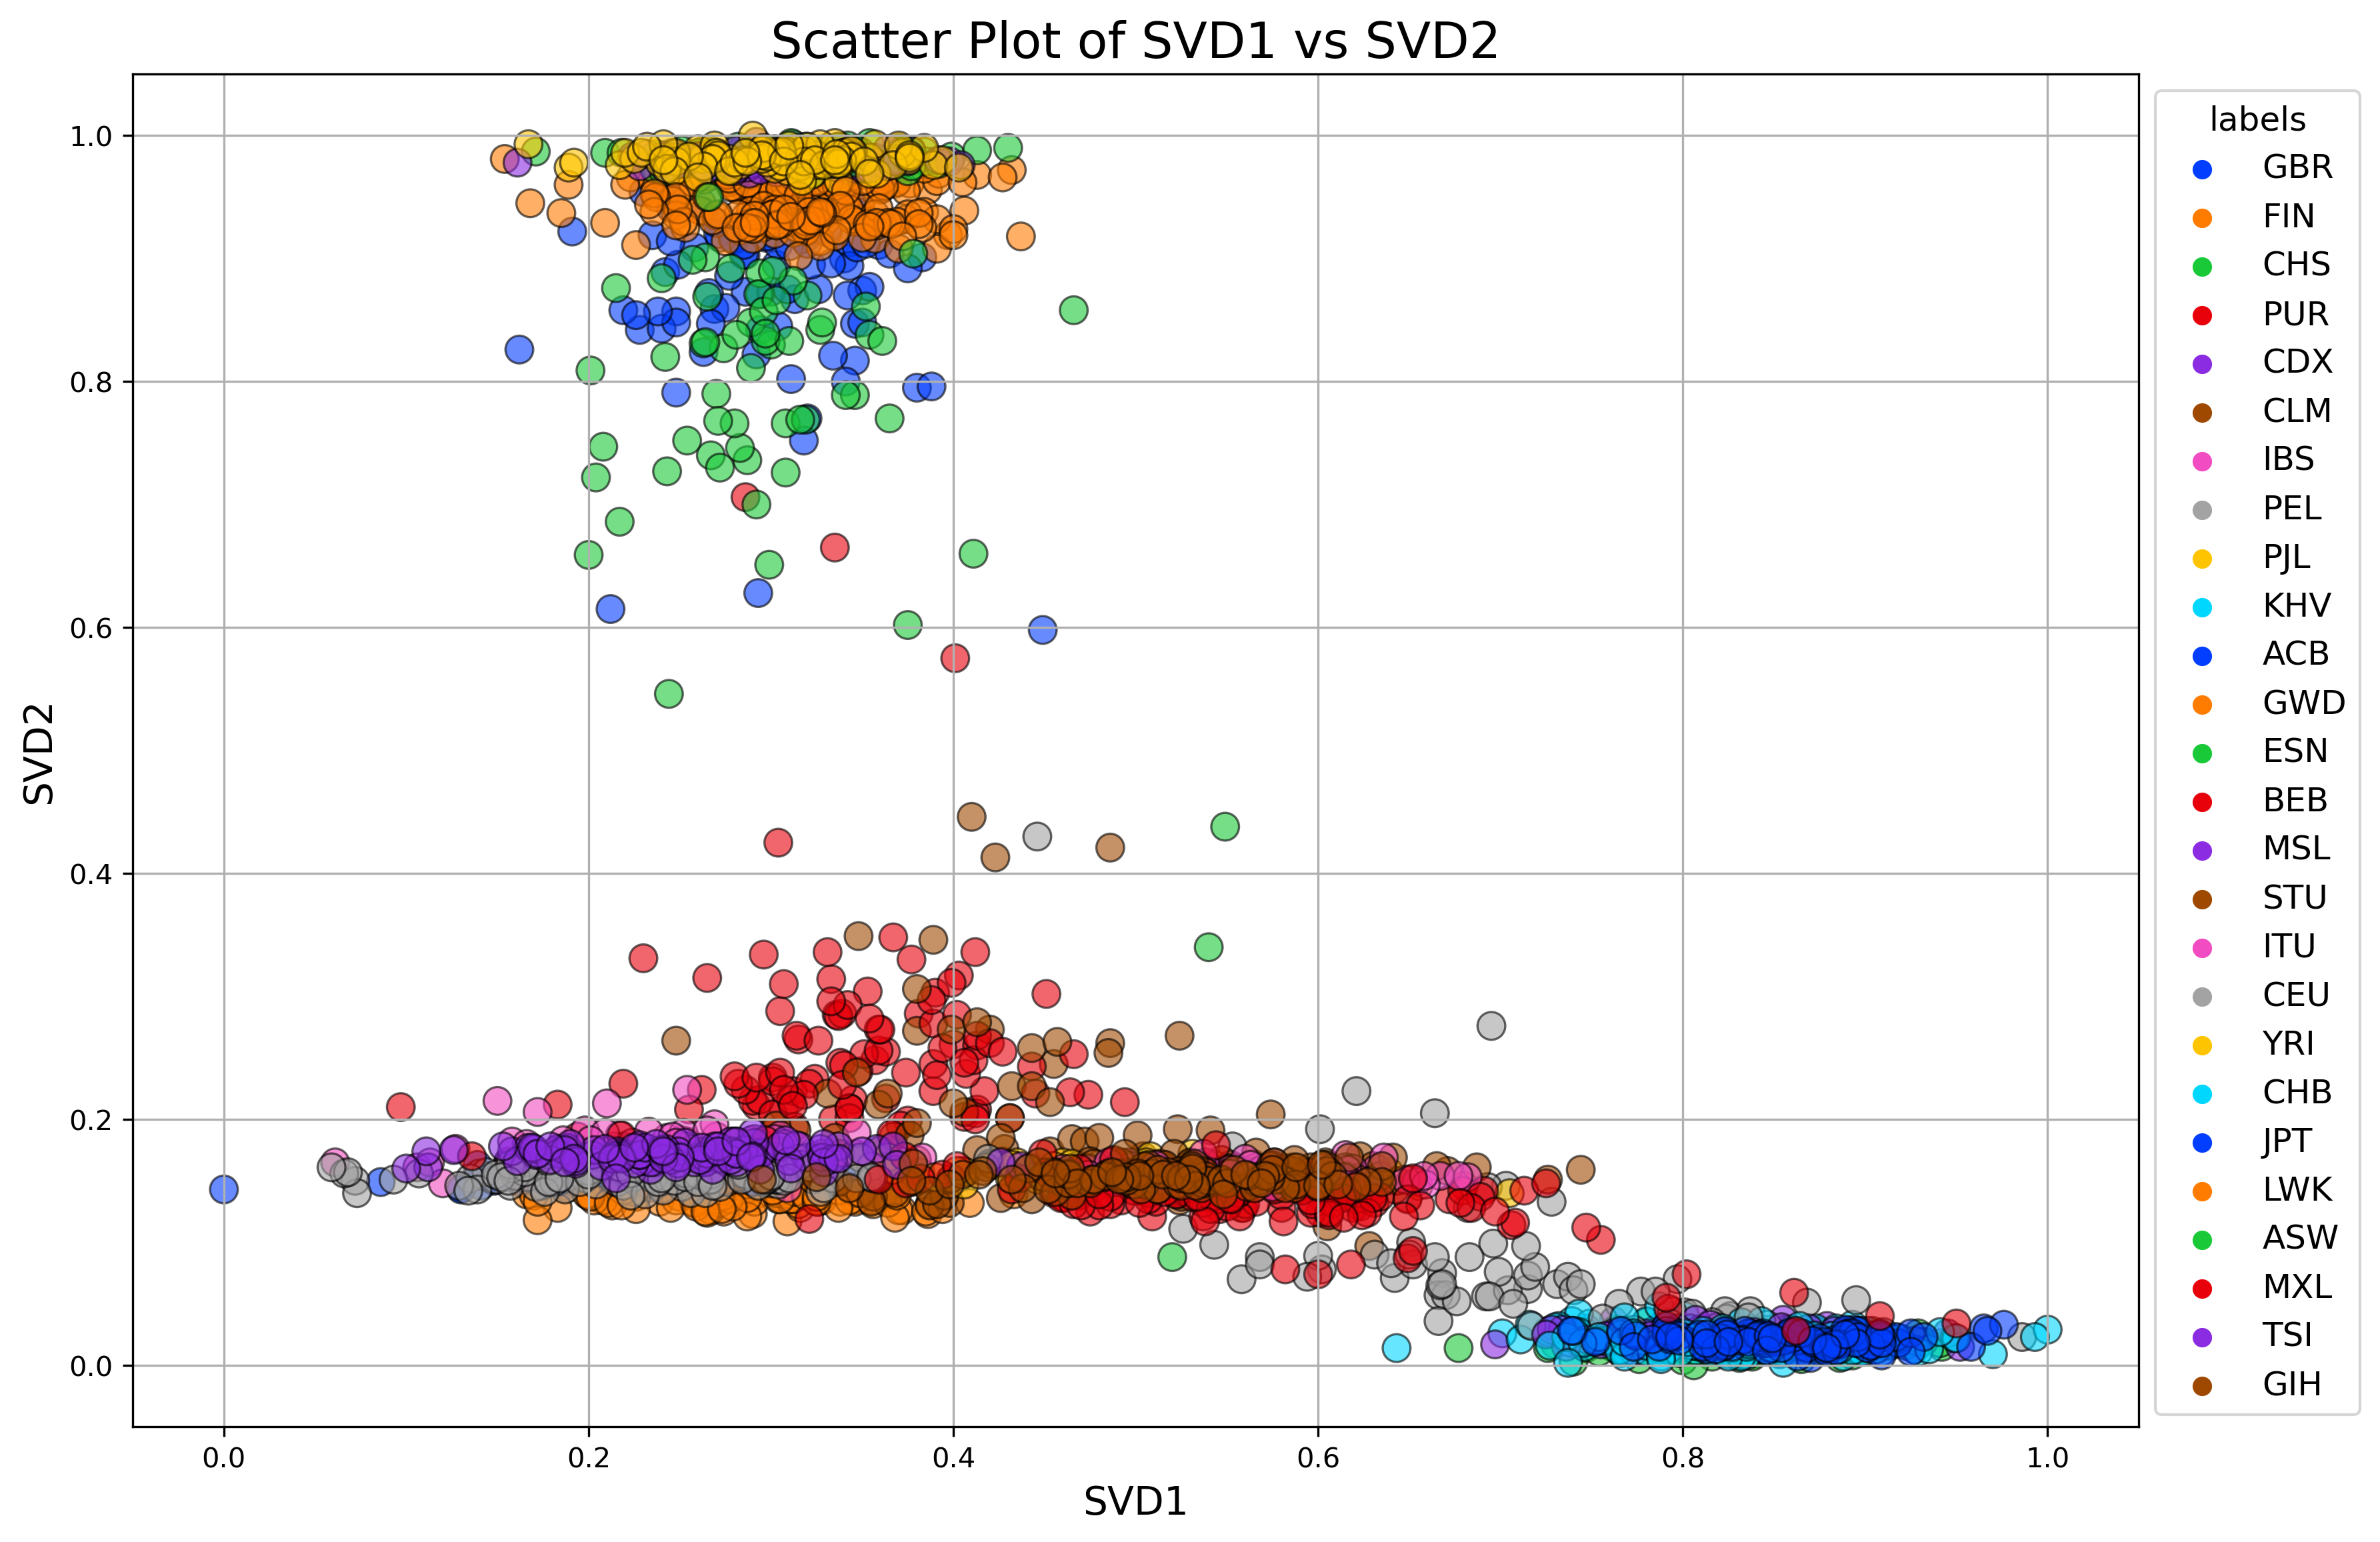

In [31]:
plot_detailed_scatter(svd, 'SVD1', 'SVD2', 'labels')

## T-SNE

In [21]:
tsne = apply_tsne(result_df)
tsne = Normalizing(tsne)
tsne = adding_label(tsne, pop_labels)
tsne = tsne.drop('Person_ID', axis=1)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f27c89cb740>
Traceback (most recent call last):
  File "/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
Attri

In [22]:
tsne.head(3)

TSNE1  TSNE2 labels
0  0.446  0.036    GBR
1  0.434  0.029    GBR
2  0.464  0.011    GBR

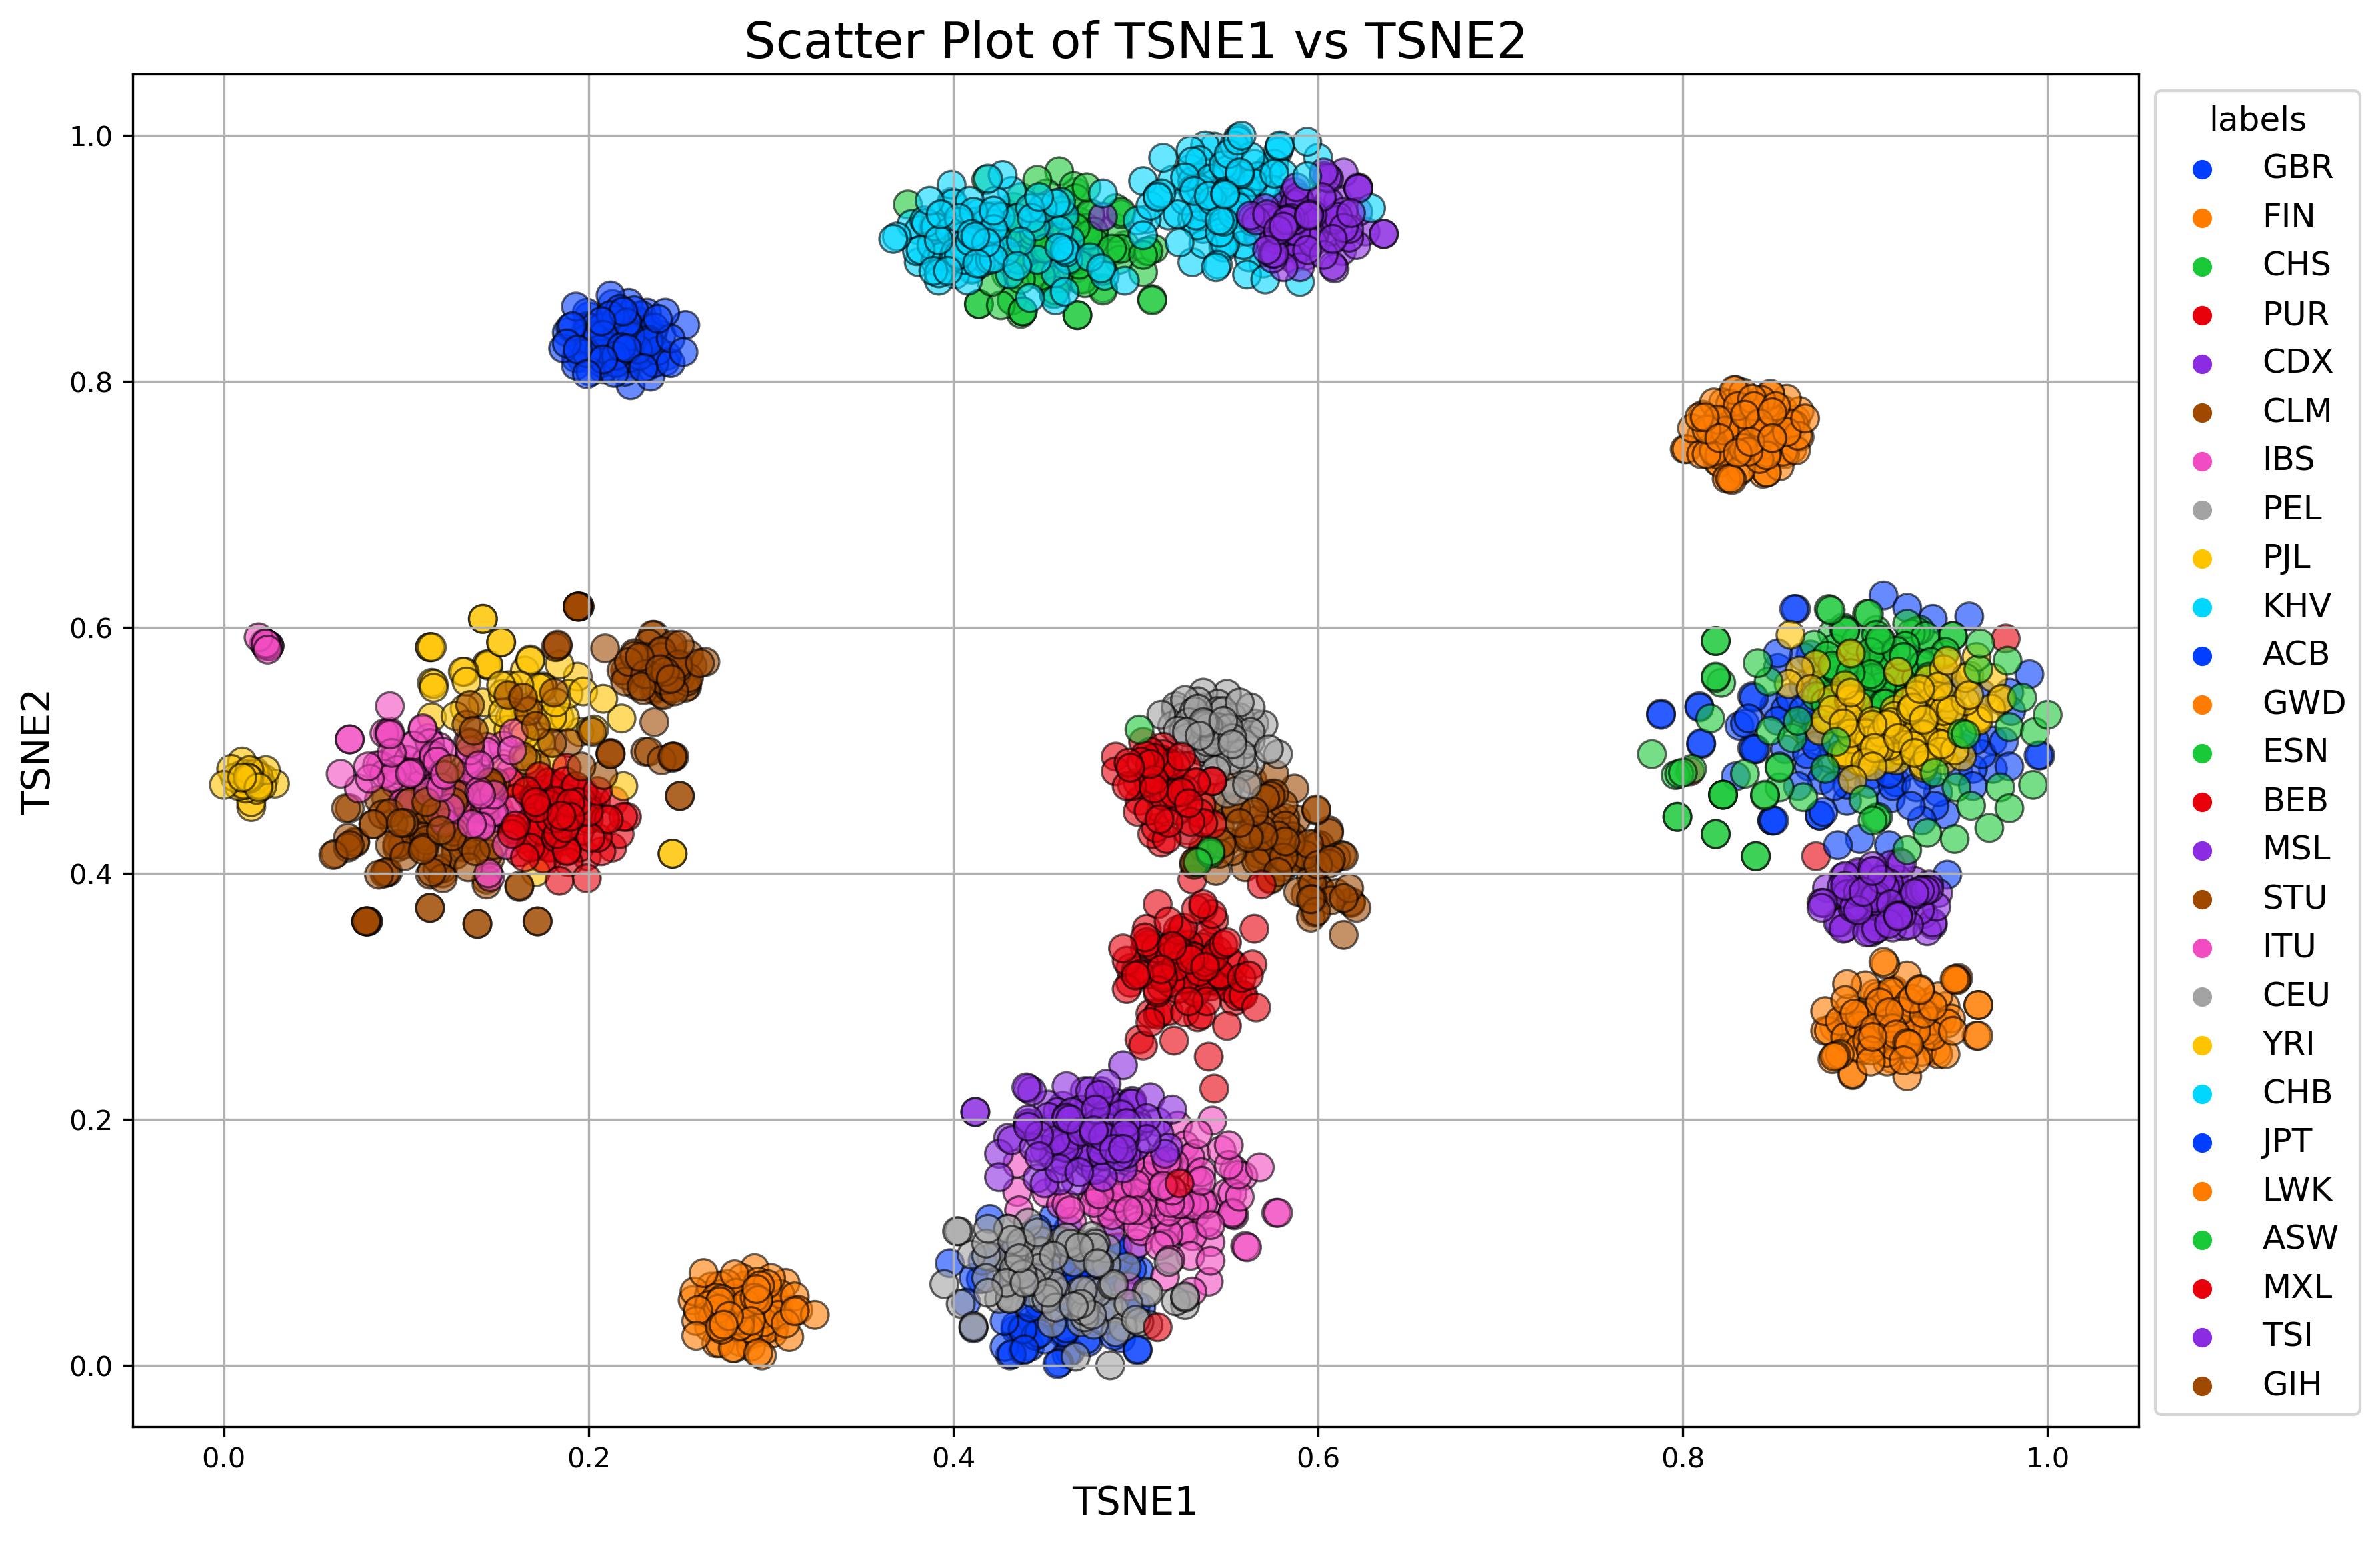

In [32]:
plot_detailed_scatter(tsne, 'TSNE1', 'TSNE2', 'labels')

## UMAP

In [24]:
umap = apply_umap(result_df)
umap = Normalizing(umap)
umap = adding_label(umap, pop_labels)
umap = umap.drop('Person_ID', axis=1)

/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [25]:
umap.head(3)

UMAP1  UMAP2 labels
0  0.407  0.110    GBR
1  0.408  0.106    GBR
2  0.401  0.113    GBR

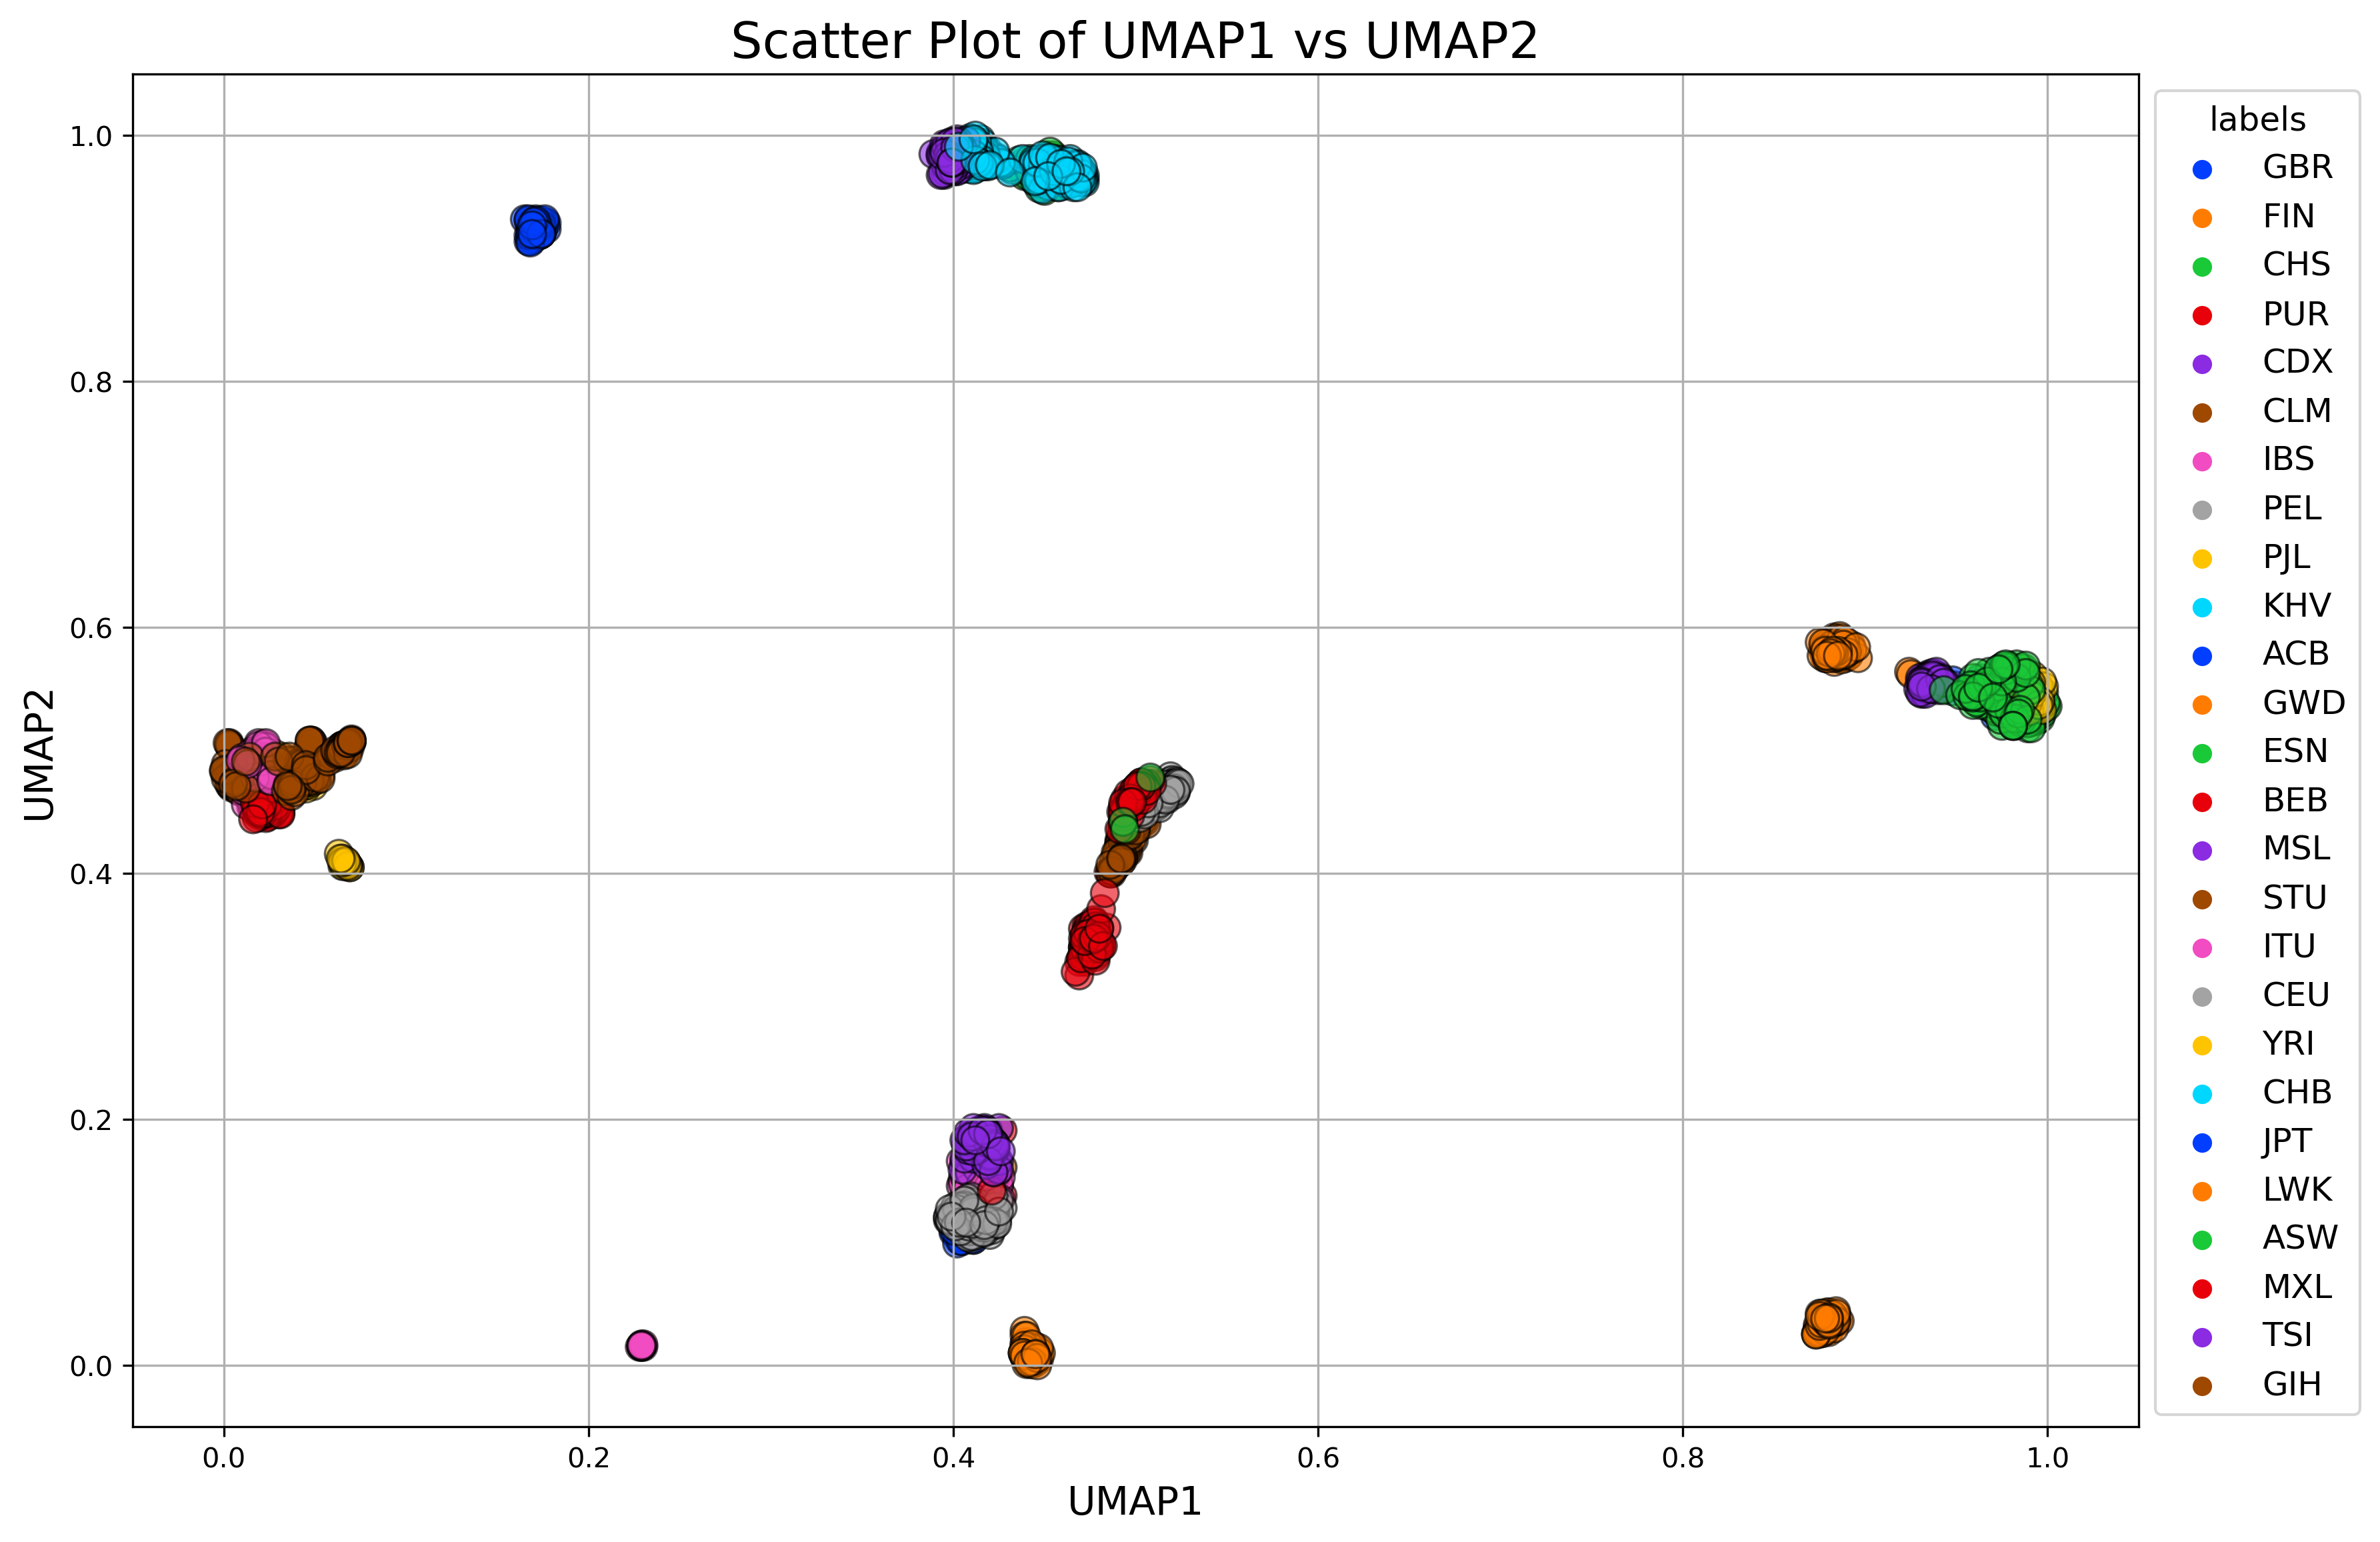

In [33]:
plot_detailed_scatter(umap, 'UMAP1', 'UMAP2', 'labels')